Hello, I started studying time series one week ago and I am not an expert in machine learning. This is my first kernel! I hope to get feedback, in particular I do not know yet how to interpret the Ljung-Box test on the bottom of this notebook.

For this competition I noticed a couple of kernels getting stuck with the number of visitors showing a sudden increase in July 2016. That happens simply because in July 2016 there are more restaurants in the data. For this reason I thought of using the mean of visitors and practice with a seasonal ARIMAX model.

## Recruit Restaurant Visitor Forecasting
Forecast restaurant visits for establishments in Japan based on historical visits and reservation data from two websites - Hot Pepper Gourmet and AirREGI. We are also given some additional metadata on the restaurants such as genre and location. Find the competition on [this link at kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)



In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%html
    <style>.container { width:90% !important;} </style>

### Read the data

NB: The number of stores with reservations = number of reservations because there's one reservation per store.
    For this reason the mean is IMO a good normalized measure of visits, mean = # visits / # reserved stores

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import calendar
# 
air = pd.read_csv('../input/air_visit_data.csv', parse_dates=[1])
air.set_index(['visit_date'], inplace=True)
air.index.name=None
air.drop('air_store_id',axis=1,inplace=True)
df2=pd.DataFrame()
df2['visit_total'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].sum()
df2['visit_mean'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].mean()
df2['reserv_cnt'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].count()
air=df2;del df2

#Get the date info with dow and holidays
hol=pd.read_csv('../input/date_info.csv', parse_dates=True).rename(columns={'calendar_date':'visit_date'})
hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol.set_index(['visit_date'], inplace=True)
hol.index.name=None
hol.day_of_week = hol.day_of_week.apply(list(calendar.day_name).index)

#Get the test submission
test = pd.read_csv('../input/sample_submission.csv')
test['store_id'], test['visit_date'] = test['id'].str[:20], test['id'].str[21:]
test.set_index('visit_date', drop=True, inplace=True)
test.index.name=None

/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


### Explorative analysis on cumulative visits
I create a series with cumulative visits, that is the sum of visits to all stores/restaurants. Notice the huge increase in July 2016 (see above). The drop comes because many restaurants did not have any data before that month. Probably the registration system started "monitoring" many new restaurants/stores in that period.  
There is also a drop in visits and reservation counts in the beginning of the years, probably due to stores being close around new year's eve.  

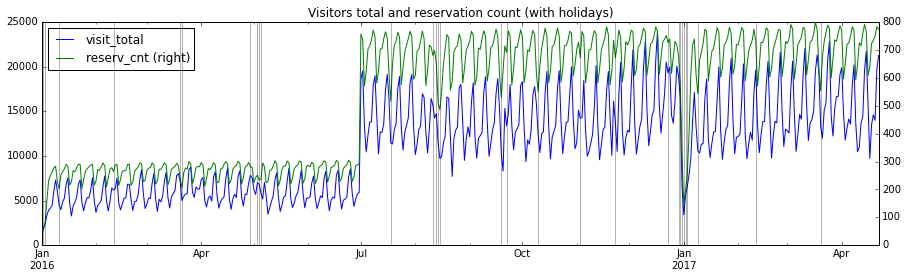

In [4]:
#Plot the cumulative visits
air['visit_total'].plot(legend=True);
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True,
                      title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

Instead of the sum of visits, a better measurement is **the mean** of the cumulative visits (sum of all visits divided by number of reservations or, which is the same, the number of "active" restaurants). The series does not show the gap in July 2016 anymore, though variance seems to become smaller for some months.

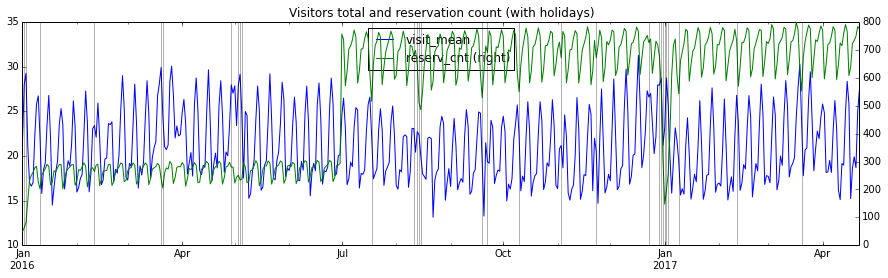

In [5]:
air['visit_mean'].plot(figsize=(15,4), legend=True, title='Visitors mean (with holidays)')
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True, title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

Applying a seasonal decomposition using moving averages. The trend captures three peaks in the data: 

* Around mid-March 2016, 
* April 2016
* Just before the drop on new year's eve 2016, 
* Again mid-March 2017 
I see on wikipedia that these are the vernal equinox (around March 20), the golden week starting on April 29, Emperor's birthday :( on December 23rd and new year's day on January 1st, vernal equinox again.  
This sounds great, though some other holidays are hardly visible in the data. I can imagine that people has the tendency to stay home in the winter.

The season plot shows a strong weekly period where the lowest number of visit happen on Monday. Below I show that people mostly do reservations between Friday and Sunday.

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


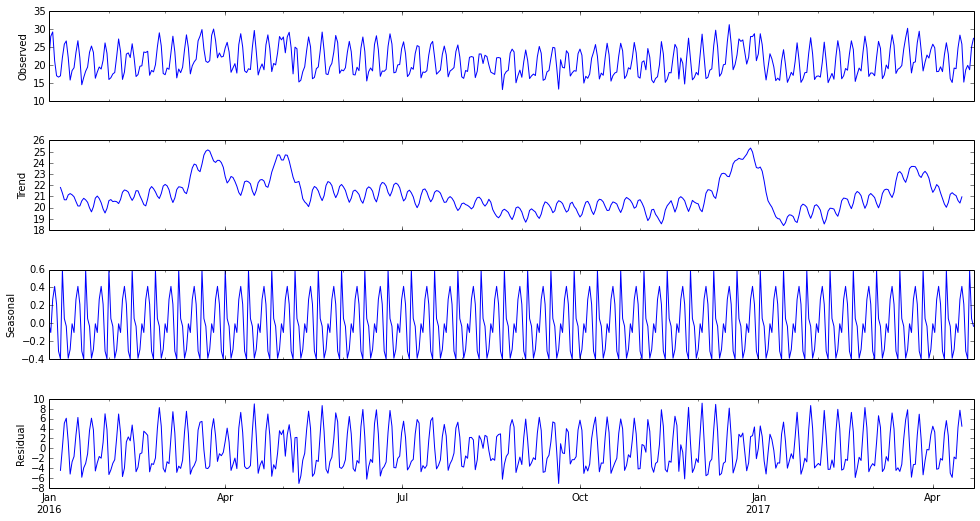

In [6]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air.visit_mean, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [7]:
df2=air.join(hol)
df2[df2.holiday_flg==0].groupby(hol.day_of_week,squeeze=True,sort=True)['visit_mean'].sum()
#df2.day_of_week=df3.day_of_week.apply(lambda x: list(calendar.day_name)[x]) # equiv to air.sum(0)

day_of_week
0     990.358277
1    1166.228003
2    1265.651637
3    1162.836395
4    1503.191793
5    1731.514759
6    1534.474447
Name: visit_mean, dtype: float64

### Pre-ARIMA analysis: make the series stationary
Stationary means that variance and autocorrelation structure not changing over time.  
Changes in mean happen when the series has a overall trend, e.g. it increases/decreasing. In that case use differentiation: create a new series y with the first difference y=x$_t$-x<sub>t-1</sub> (this is the "I" in ARIMA models), and take seasonal differences (which you can account for in ARIMA model).  
Changes is variance mean that oscillations change. To fix this a log of the series compresses oscillations.  
Changes in autocorrelation means that oscillations become broader (or narrower). If you have this I think you are screwed..

The Dickey-Fuller test helps us deciding whether a series is stationary. The test's null hypothesis is that the series is non-stationary. If the Test Statistic output of the Dickey-Fuller test is less than the Critical Value, we can reject the null hypothesis and say that the series is stationary.  
Below we notice that the original time series (using the mean of visits) is fairly stationary: Test Statistic=-3.796104 > Critical Value (1%) = -3.444615. Applying 1st or seasonal differentiation greatly improves the test results (Test Statistic = -6.608968 and 7.196314, respectively). A weekly periodic structure is clearly visible in the data, so I lean towards using seasonal differentiation. 
Takign the log of the data helps but does not seem to be a main factor in improving stationarity. This means that variance is fairly stable. 

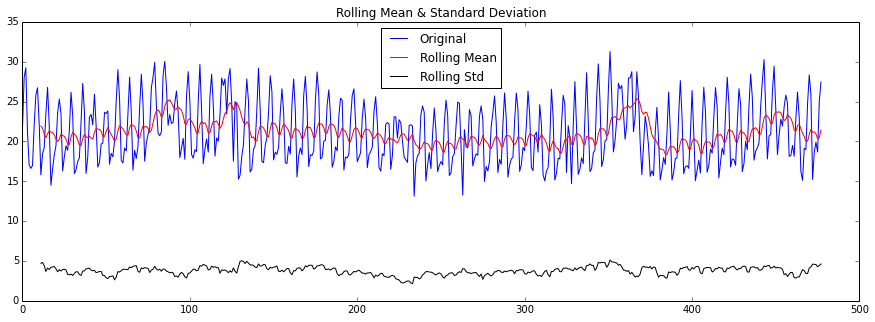

Results of Dickey-Fuller Test:
Test Statistic                  -3.796104
p-value                          0.002947
#Lags Used                      16.000000
Number of Observations Used    461.000000
Critical Value (5%)             -2.867830
Critical Value (1%)             -3.444615
Critical Value (10%)            -2.570120
dtype: float64


'test_stationarity(air.visit_mean_log) #-3.830754'

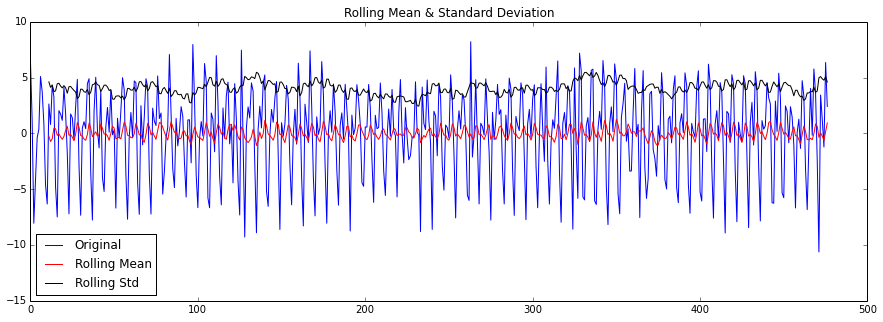

Results of Dickey-Fuller Test:
Test Statistic                -6.608968e+00
p-value                        6.448883e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (5%)           -2.867871e+00
Critical Value (1%)           -3.444709e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


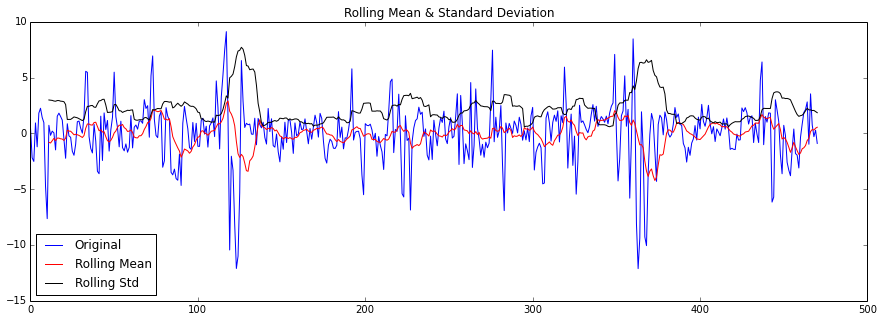

Results of Dickey-Fuller Test:
Test Statistic                -7.196314e+00
p-value                        2.429479e-10
#Lags Used                     1.500000e+01
Number of Observations Used    4.550000e+02
Critical Value (5%)           -2.867913e+00
Critical Value (1%)           -3.444804e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


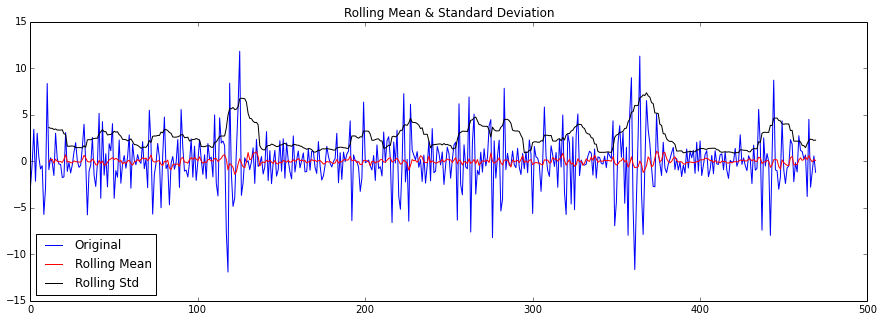

Results of Dickey-Fuller Test:
Test Statistic                -9.427797e+00
p-value                        5.288819e-16
#Lags Used                     1.600000e+01
Number of Observations Used    4.530000e+02
Critical Value (5%)           -2.867941e+00
Critical Value (1%)           -3.444868e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(air.visit_mean); #-3.796104
# Log is a minor improvement, meaning that the variance is stable
air.visit_mean_log= air.visit_mean.apply(lambda x: np.log(x))  
'''test_stationarity(air.visit_mean_log) #-3.830754'''
# Although I see no real global trend, 1st difference strongly improves stationarity
air['visit_mean_diff'] = air.visit_mean - air.visit_mean.shift(1)  
test_stationarity(air.visit_mean_diff.dropna(inplace=False)) #-6.608968e+00
# Seasonal difference: take a weekly season improves stationarity even more
air['visit_mean_seasonal'] = air.visit_mean - air.visit_mean.shift(7)
test_stationarity(air.visit_mean_seasonal.dropna(inplace=False)) #-7.196314e+00
# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
air['visit_mean_seasonal_diff'] = air.visit_mean_diff - air.visit_mean_diff.shift(7)
test_stationarity(air.visit_mean_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

mmm, let's stick to the seasonal series with **no 1st difference**. We will run auto-SARIMAX later and see if it makes sense. 

Let's run autocorrelation ACF and partial autocorrelation PACF for find the details fo the model. I will use the guidelines [here](http://people.duke.edu/~rnau/arimrule.htm).

The following ACF on the mean visits has a repeated pattern. That's our 7-day seasonal term. I should add to the model seasonal differenciation in the term **seasonal\_order=( , 1, ,7)**.  
If ACF was positive and decreasing over time, the series would be the typical candidate for applying 1st difference. But not here. This confirms the observation we made on the Dickey-Fuller test where the 1st difference was more stationary but not that much. I should add a **order=( , 0, ) term** to the model. Also try a constant term **trend='c'** in the model for the non-zero mean value.

ACF and PACF of the visit mean:


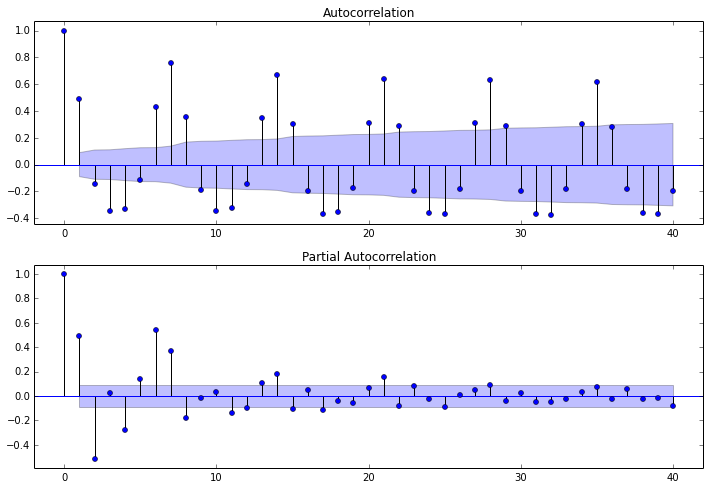

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean, lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean, lags=40, alpha=.05, ax=ax2)
print("ACF and PACF of the visit mean:")

This is the ACF of the first difference, confriming the 7-day seasonal term. 

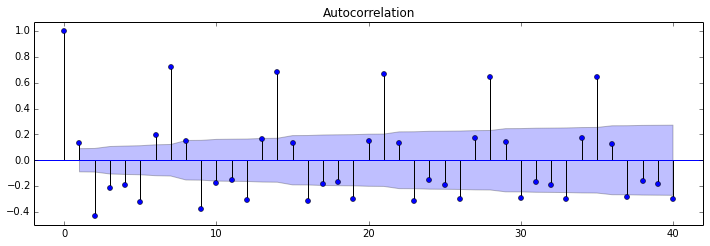

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_diff[1:], lags=40, alpha=.05, ax=ax1)

The ACF and PACF below are plotted the seasonal difference data.

The PACF of the seasonal differenced series is positive at lag=1 (the series appears slightly "underdifferenced"). I should probably add one AR term to the model **order=(2, , )**. Only one AR term because the term at lag=2 cuts off and enters the 95% confidence interval. 

As for the PACF, the ACF of the seasonal differenced series is overdifferentiated at lag = 1 and cuts off (which I looked on the internet and means "go to zero") at lag=2. I should probably add one MA term to the model **order=( , , 2)**.

The ACF of the differenced series is negative at lag 7, suggesting to add a seasonal MA term **seasonal\_order=(0, , 1, )** to the model. This situation is likely to occur if a seasonal difference has been used, which should be done if the data has a stable and logical seasonal pattern. If the peak was positive I would have added a season AR term. The link above suggests to avoid using more than one or two seasonal parameters (SAR+SMA) in the same model to avoid overfitting and/or problems in estimation.



ACF and PACF of the 7-day differenced visit mean:


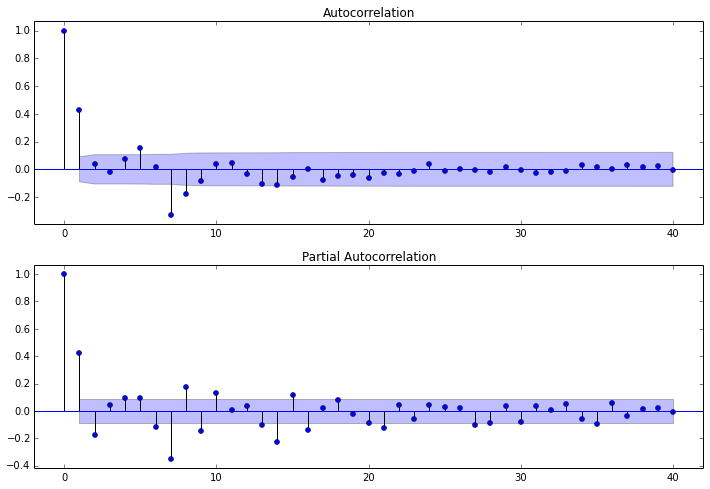

In [11]:
print("ACF and PACF of the 7-day differenced visit mean:")
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax2)

More things to keep in mind:  
Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.  
Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.  
Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

### SARIMA model 
[SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) = Seasonal Auto Regressive Integrated Moving Average (without eXogenous regressors).  
First some helper functions to calculate errors, plot SARIMAX models, and do a grid search on the hyperparamenters of SARIMAX

In [12]:
#sklearn.metrics .mean_squared_log_error seems to exist but I cannot load it..
from sklearn.metrics import mean_squared_error
def mean_squared_log_error(y_pred, y_true, **dict):
    '''Assume y_true starts earlier than y_pred, y_true is NaN free, and NaN in y_pred are only in the beginning'''
    indafterNaN = y_pred.first_valid_index()
    if (y_true.index[0] > y_pred.index[0]): return "Check indices of prediction and true value"
    ind1stcommon = y_true.index[y_true.index==y_pred.index[0]]
    indstart = max(indafterNaN, ind1stcommon)
    indend = y_true.index[-1]
    return mean_squared_error(np.log(y_true[indstart:indend]+1), 
                              np.log(y_pred[indstart:indend]+1) )**0.5

def plotSARIMAX(labels, pred):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    labels.plot(ax=ax1);
    pred.plot(ax=ax1, title='MSE: %.4f'% mean_squared_log_error(pred, labels))
    ax3 = sm.graphics.tsa.plot_acf(results.resid, lags=40, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(results.resid, lags=40, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    print("ACF and PACF of residuals")

In [15]:
from scipy.optimize import brute
from sklearn.metrics import mean_squared_error

def autoSARIMAX(endog, exog=None, date_train_end=None, pred_days=[-12,12], verbose=True,\
        ranges=(slice(1,3),slice(0,1),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8))):
    #Instantiate my version of the grid with parameters and scores
    global grid
    grid = []
    #Get indices up to which you do train and prediction 
    if date_train_end is None:
        ind_train = endog.index[-1]
    else:
        ind_train = np.where(endog.index==date_train_end)[0][0]
    #Brute optimization
    resultsbrute = brute(runSARIMAX, ranges=ranges, args=(endog,exog,(ind_train,pred_days),), full_output=True, finish=None)
    #First coefficients run two times for some reason or another
    del grid[0]
    #Print/Plot results
    if verbose:
        print("Best parameters: {}".format([int(p) for p in resultsbrute[0]]))
        print("Best score:          {}".format(resultsbrute[1]))
        gr = plotautoSARIMAX(resultsbrute, verbose)
    return resultsbrute, gr

def plotautoSARIMAX(resultsbrute, verbose=True):
    #Print/Plot results
    if not verbose: return None
    #Plot scores by parameter values
    gr = pd.DataFrame({'params':[''.join(str(n) for n in g[0]) for g in grid], 'score': [row[1] for row in grid], 'aic': [row[2] for row in grid]})
    print("All parameters and scores: \n")
    print(gr.head(1000).to_string())
    ax1 = gr.plot('params','score',rot=90, grid=True, figsize=(15,4))
    ax2 = gr.plot('params','aic',rot=90, secondary_y=True,ax=ax1)
    ax1.set_ylabel('Score');ax2.set_ylabel('AIC');
    plt.xticks(range(len(gr)), gr.params, rotation=90);
    return gr

def runSARIMAX(coeffs, *args):
    endog = args[0]
    exog = args[1]
    #Process the row indices for training and prediction
    ind_train = args[2][0]
    pred_days = args[2][1]
    ind_pred = [len(endog)+pred_days[0], len(endog)+pred_days[1]]
    if ind_pred[0] > ind_train: 
        #ind_pred[0]=ind_train
        raise ValueError('Make sure prediction bounds begin at least at len(endog): pred_days[0] must be <= %i ' % (ind_train-len(endog)))
    exog_train, exog_pred, start_params = None, None, list()
    if exog is not None:
        if ind_pred[1] > len(exog):
            raise ValueError('Make sure prediction bounds end  <= len(exog): pred_days[1] must be <= %i ' % (len(exog)-len(endog)))
        exog_train = exog[:ind_train]
        exog_cols = 1 if len(exog.shape) == 1 else exog.shape[1]
        start_params.extend(0.1*np.ones(exog_cols-1))
        exog_pred = exog[ind_pred[0]-1:ind_pred[1]]
        exog_pred = pd.DataFrame(exog_pred)
        
    #Get the hyperparameters
    order = coeffs[0:3].tolist()
    seasonal_order = coeffs[3:7].tolist()
    trend = 'c' if (order[1]==0) else 'n'
    #Train SARIMAX and fit it on data, predict to get scores
    try:        
        mod = sm.tsa.statespace.SARIMAX(endog[:ind_train], exog_train, \
                                        trend=trend, order=order, seasonal_order=seasonal_order)
        start_params.extend(0.1*np.ones( len(mod.params_complete)))
        fit = mod.fit(start_params=start_params)
        pred = fit.predict(start=ind_pred[0], end=ind_pred[1], exog=exog_pred)
        aic = fit.aic
        score = mean_squared_log_error(pred[:-pred_days[0]], endog[ind_pred[0]:])        
        if np.isnan(aic): aic, score = np.inf, np.inf
    except:  #Tip: Try to set starting paramenters in .fit()
        import sys        
        print("Error:", sys.exc_info())        
        print("{},{},'{}', len(start_params)={}\n".format(coeffs[0:3], coeffs[3:], trend, len(start_params)))
        aic, score = np.inf, np.inf
    #Sorry but I don't like the grid in the output of brute resultsbrute[2]
    global grid
    grid.append([coeffs,score,aic])
    return score

#Quick example
#resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=None, date_train_end="2017-03-26", pred_days=[-28,66],\
#                             ranges=(slice(1,2),slice(0,1),slice(1,2),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))

#resbrute, gr=autoSARIMAX(endog=air.visit_mean, exog=hol.holiday_flg, date_train_end="2017-03-26", pred_days = [-28,39],\
#                    ranges=(slice(1,2),slice(0,1),slice(1,2),  slice(0,1),slice(1,2),slice(1,2),slice(7,8)))

Run grid search on Seasonal ARIMA models to explore the best ones

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best parameters: [1, 0, 2, 1, 1, 1, 7]
Best score:          0.068181248716
All parameters and scores: 

            aic   params     score
0   1862.338438  1010117  0.078648
1   1847.449127  1011117  0.075009
2   1837.934213  1020117  0.069904
3   1833.528949  1021117  0.068181
4   1872.663605  1110117  0.092025
5   1861.546482  1111117  0.089539
6   1845.481772  1120117  0.101354
7   1839.896175  1121117  0.103045
8   1861.588416  2010117  0.077761
9   1847.325281  2011117  0.074791
10  1837.873271  2020117  0.070029
11  1832.899531  2021117  0.070025
12  1838.895742  2110117  0.115152
13  1835.609463  2111117  0.119439
14  1838.895007  2120117  0.115802
15  1835.560306  2121117  0.118234


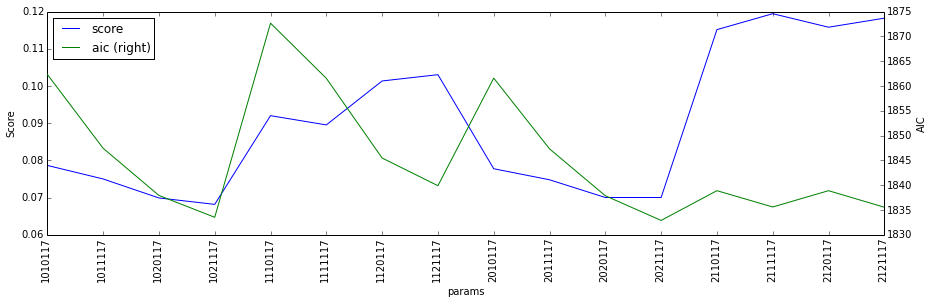

In [16]:
resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=None, date_train_end="2017-03-26", pred_days = [-28,39],\
                             ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))
#Not shown, but the SMA parameter is important to keep to 1

The autoSARIMAX function evaluates models based on the mean squared log error used in the competition, but the aic Akaike information criterion estimating the quality of the statistical model is also plotted. The two scores seem to be in reasonable agreement.  
Interestingly, 1st differentiation (the second 'd' hyperparamenter) does not seem to be necessary to obtain a good model. This confirms the analysis above. Because overdifferentiating is bad, I will stick to d=0: **( , 0, )x( , 1, , 7)**.   
Although I do not show it the second to last term (SMA) is important and should be at least 1: **( , , )x( , , 1, )**. When I evaluate models with SMA=0 they are always worse and show an ugly zig zag plot.  
The model we had from our analysis is **(2,0,2)x(0,1,1,7)**. Model **(2,0,2)x(1,1,1,7)** next to it in the plot has a slightly better Akaike Information Criterion score. Other models with more complexity (e.g. 2031117 or 3021117) are slightly better, but I'd rather keep the model simple.  
I am tempted to choose model **(1,0,2)x(1,1,1,7)**, which is simpler and with a decent score. Probably in this model the first hyperparamenter AR=1 (instead of AR=2 from our analysis above) is compensated by the fourth hyperparamenter SAR=1 (instead of SAR=0 from our analysis). I will go for this model.   

Running SARIMAX **(1,0,2)x(1,1,1,7)**: the weekly oscillations are nicely captured but the autocorrelation plots show some structure in the residuals.  
NB: in my plots predictions (green time series) are entirely calculated on untrained region of the plot so that I can estimate predictions and true values where they overlap. Training the model on the whole labels would lead to better match in the overlapping region but the model would be prone to overfitting.

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  450
Model:             SARIMAX(1, 0, 2)x(1, 1, 1, 7)   Log Likelihood                -907.300
Date:                           Tue, 12 Dec 2017   AIC                           1828.600
Time:                                   22:00:36   BIC                           1857.364
Sample:                               01-01-2016   HQIC                          1839.937
                                    - 03-25-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.001     -0.377      0.706      -0.003       0.002
ar.L1          0.9421      0.031     29.987

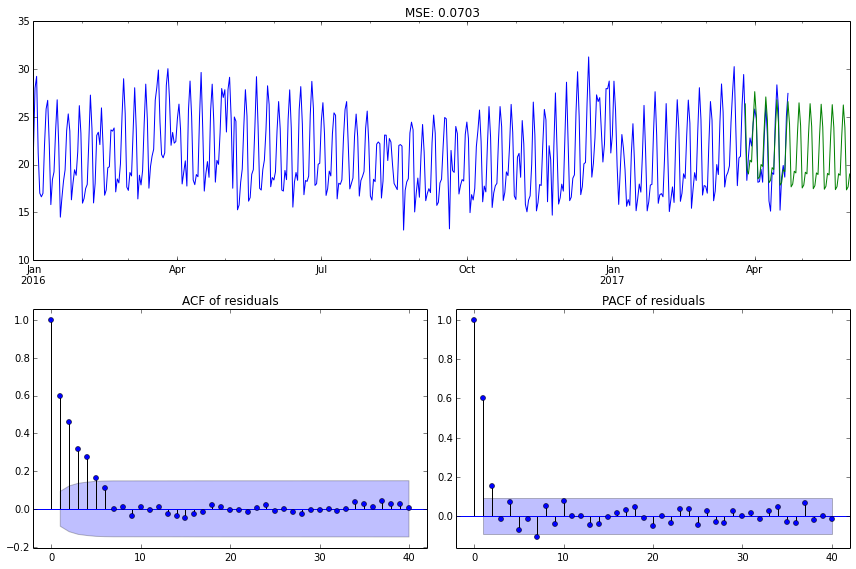

In [17]:
mod = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', order=(1,0,2), seasonal_order=(1,1,1,7))
results = mod.fit()
#Predict on future data and on time periods already known for evaluation with RMSLE
pred = results.predict(start=450, end=516)
print(results.summary())
#Plot
plotSARIMAX(air.visit_mean, pred)

Adding 1st order differentiation does not work (you get nan coefficients, not shown)

### SARIMAX with eXogenous dataset

Let's introduce holidays in the fit. The holidays column can be assed to the X of SARIMAX as eXogenous regressors. I first run the optimizer on SARIMAX

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

Best parameters: [2, 0, 2, 1, 1, 1, 7]
Best score:          0.0670307292243
All parameters and scores: 

            aic   params     score
0   1788.925314  1010117  0.081216
1   1764.617581  1011117  0.075212
2   1759.757781  1020117  0.073947
3   1747.379893  1021117  0.070833
4   1782.025888  1110117  0.090565
5   1765.453635  1111117  0.092104
6   1765.083706  1120117  0.096073
7   1752.677707  1121117  0.099348
8   1788.370544  2010117  0.080282
9   1764.493836  2011117  0.074863
10  1759.583021  2020117  0.074433
11  1752.876904  2021117  0.067031
12  1755.585294  2110117  0.105431
13  1747.055140  2111117  0.110026
14  1753.768831  2120117  0.108168
15  1746.191477  2121117  0.112743


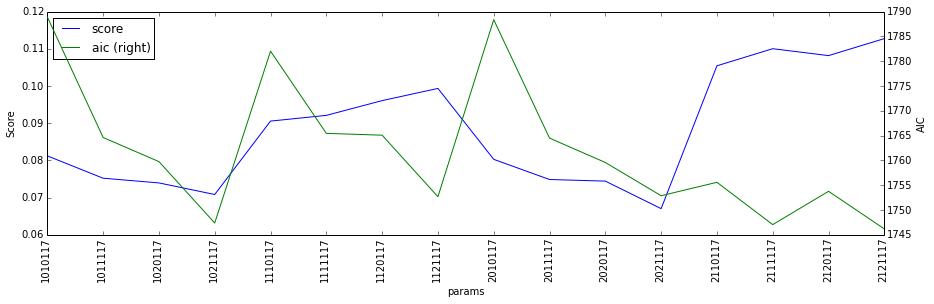

In [18]:
resbrute, gr=autoSARIMAX(endog=air.visit_mean, exog=hol.holiday_flg, date_train_end="2017-03-26", pred_days=[-28,39],\
                    ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))

The results for the optimization using holidays as exogenous regressors shows a very similar behavior as before. I stick to model (2,0,2)x(1,1,1,7).  
Now I fit that model. In the plot of the time series notice that the prediction is already much better. I don't show that but if you start the prediction earlier than shown below it would capture the peak on new year's eve. Our forecast now predicts a peak on the weekend of the golden week in April 2017, which is very plausible

In [ ]:
modx = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', exog=hol.holiday_flg[:450],\
                                 order=(1,0,2), seasonal_order=(1,1,1,7))
resultsx = modx.fit(start_params=0.1*np.ones( len(modx.param_terms)-2+ 2*2 ))
#Predict on future data and on time periods already known for evaluation with RMSLE
predx = resultsx.predict(start=450, end=516, exog=pd.DataFrame(hol.holiday_flg[450:]))
print(resultsx.summary())
plotSARIMAX(air.visit_mean, predx)

In [ ]:
resbrute, gr = autoSARIMAX(endog=air.visit_mean, exog=hol, date_train_end="2017-03-26", pred_days=[-28,39],\
                    ranges=(slice(1,3),slice(0,2),slice(1,3),  slice(0,2),slice(1,2),slice(1,2),slice(7,8)))

From the plot of auto-SARIMAX above notice that the relative did not change much. The (1, 0, 2)x(1, 2, 1, 7) model used so far shows a dip and only more complex models get lower than that. 
The plot below shows that adding the day of the week column as exogenous regressors does not change the error and quality of the fit so much. Maybe that is because we already have a season of 7 days.  
The autocorrelation of residuals has not improved and shows some structure.

In [ ]:
modx2 = sm.tsa.statespace.SARIMAX(air.visit_mean[:450], trend='c', exog=hol[:450], order=(1,0,2), seasonal_order=(1,1,1,7))
resultsx2 = modx2.fit(start_params=0.1*np.ones( len(modx2.params_complete)))
#Predict on future data and on time periods already known for evaluation with RMSLE
predx2 = resultsx2.predict(start=450, end=516, exog=hol[450:])
print(resultsx2.summary())
plotSARIMAX(air.visit_mean, predx2)

**Todo**

* I have the feeling that including the number of open restaurants/reservations (or similar) will certainly be necessary when moving to the visitor data without mean, and it might help as exogenous model will improve modeling certain periods
* I was expecting more reservations in the summer, but maybe Japanese people go on vacation? I thought they had to work all the time
* Repeat the analysis after aggregating restaurants by regions and cuisine. How much will the models differ?
* Better the ACF of residuals
* Better understand Ljung-Box test: shouldn't there be a critical value? How to interpret Prob(Q)?



see autocorrelation of residuals!
https://tomaugspurger.github.io/modern-7-timeseries.html

 
http://www.chadfulton.com/topics/state_space_diagnostics.html


Although there are many available tests, Durbin and Koopman (2012) and Harvey (1990) suggest three basic tests as a starting point:

Normality: the Jarque–Bera test
Heterskedasticity: a test similar to the Goldfeld-Quandt test
Serial correlation: the Ljung-Box test
These have been added to Statsmodels in this pull request (2431), and their results are added as an additional table at the bottom of the summary output (see the table below for an example).

Furthermore, graphical tools can be useful in assessing these assumptions. Durbin and Koopman (2012) suggest the following four plots as a starting point:

A time-series plot of the standardized residuals themselves
A histogram and kernel-density of the standardized residuals, with a reference plot of the Normal(0,1) density
A Q-Q plot against Normal quantiles
A correlogram
To that end, I have also added a plot_diagnostics method which creates those following four plots.

In [ ]:
asdasdasd

### Todo 
* Understand Ljung-Box test: shouldn't there be a critical value? Prob(Q) = 0 sounds bad
* I have the feeling that including the number of open restaurants/reservations (or similar) will certainly be necessary when moving to the visitor data without mean, and it might help as exogenous model will improve modeling certain periods  
* I was expecting more resrvations in the summer, but maybe Japanese people go on vacation? I thought they had to work all the time  
* I did some attempts and I could not succesfully use a yearly season + day of the week as exogenous regresson  
* Try different parameters for the SARIMAX models  
* Repeat the analysis after aggregating restaurants by regions and cuisine. How will the models differ?  

In [ ]:
air = pd.read_csv('../input/air_reserve.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hpg = pd.read_csv('../input/hpg_reserve.csv')
hpgstore = pd.read_csv('../input/hpg_store_info.csv')

air = pd.merge(air,airstore,on='air_store_id')
hpg = pd.merge(hpg,hpgstore,on='hpg_store_id')
rel = pd.read_csv('../input/store_id_relation.csv')
airrel = pd.merge(air,rel,how='left',on='air_store_id')
hpgrel = pd.merge(hpg,rel,how='left',on='hpg_store_id')
full = pd.merge(airrel,hpgrel,how='outer')
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

Use KMeans to group locations in 10 regions. See https://www.kaggle.com/asindico/a-japanese-journey

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]
'''
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/10) for i in range(10)]
colored = [colors[k] for k in full['cluster']]
f,axa = plt.subplots(1,1,figsize=(15,16))
m.drawcoastlines()
m.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)
m.scatter(full.longitude.values,full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)
plt.setp(axa.get_yticklabels(), visible=True)
plt.annotate('Kyushu', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)
plt.annotate('Chugoku', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)
plt.annotate('Kinki', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)

for i in range(len(cx)):
    xpt,ypt = m(cx[i],cy[i])
    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)
plt.show()'''

Grid search on SARIMAX

In [ ]:
import pandas as pd    
y = np.array([0,1,4,9,16]) + 3 #polynomial x^2+3 with x=0:4
def objfunc(coeffs, *args):
    arr = args[0]                       # access first element of tuple: y
    exp = coeffs[0]                       #     assuming y should become endog
    const = coeffs[1]
    pol = [i**exp + const for i in range(len(y))]
    print(coeffs)
    return abs(sum(pol) - sum(arr))

from scipy.optimize import brute
grid = (slice(1, 3, 1), slice(2, 5, 1))
resbrute = brute(objfunc, ranges=grid, args=(y,), full_output=True, finish=None)
print("Best coeffs: {}".format(resbrute[0]))
print("Score with best coeffs: {}".format(resbrute[1]))
print("Grid: {}".format(resbrute[2].tolist()))
print("Scores for grid: {}".format(resbrute[3].tolist()))

In [ ]:
import seaborn as sns
corr_matrix = train_data['col1','col2'].corr().round(2)
fig = plt.figure(figsize=(12,12));
sns.heatmap(corr_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()